<h2 style="text-align: center;">Projeto Semestral</h2>
<h3 style="text-align: center;">Predição de Doenças Cardíacas com IA</h3>

<hr>

<p style="text-align: center; font-size: 14px;"><b>Discentes:</b> Arthur Henrique Soqueira Pantaleão,Lucas Daris de Souza, Nivaldo Pereira</p>
<p style="text-align: center; font-size: 14px;"><b>Docente:</b> Marcelo J. S. C. de Almeida</p>

<hr>

<p style="text-align: center; font-size: 14px;"><b>Instituição:</b> IFPB - Campus Campina Grande</p>
<p style="text-align: center; font-size: 14px;"><b>Curso:</b> Engenharia da Computação</p>
<p style="text-align: center; font-size: 14px;"><b>Disciplina:</b> Inteligência Artificial</p>
<p style="text-align: center; font-size: 14px;"><b>Local e Ano:</b> Campina Grande, PB - 2025</p>

# Neste notebook, realizamos o pré-processamento dos dados, aplicamos técnicas de tratamento de outliers, 
# conversão de variáveis, transformação de skewness, criação de dashboards para exploração dos dados 
# e, finalmente, treinamos e avaliamos vários modelos de Inteligencia Artificial.
#
# **Etapas abordadas:**
## 1. Análise inicial e tratamento de dados (nulos, duplicatas e remoção de colunas desnecessárias).  
## 2. Tratamento de outliers com base no IQR (remoção ou winsorização).  
## 3. Conversão de variáveis categóricas e transformação de skewness em variáveis numéricas.  
## 4. Criação de dashboards para visualização das distribuições e correlações dos dados.  
## 5. Modelagem: definição de pipelines para diversos modelos e ajuste com GridSearchCV.  
## 6. Dashboard de resultados dos modelos (comparação de métricas).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew
from matplotlib.ticker import MaxNLocator
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
url = "https://raw.githubusercontent.com/Nivaldo-Neto-IF/heart/refs/heads/main/heart%20-%20heart.csv"
df = pd.read_csv(url)


## Nesta seção, exibimos informações gerais sobre o dataset e realizamos:
## - Exibição do resumo e estatísticas descritivas.
## - Verificação de valores nulos e duplicatas.
## - Remoção de linhas duplicadas.

In [3]:
df.info()
print(df.head())
print("\nEstatísticas descritivas:")
print(df.describe())
print("\nValores nulos por coluna:")
print(df.isnull().sum())
print("\nNúmero de linhas duplicadas:", df.duplicated().sum())

# Remover linhas duplicadas
df.drop_duplicates(inplace=True)
print("\nLinhas duplicadas removidas. Linhas restantes:", df.shape[0])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187   

## Criação de uma função para a geração de graficos para a analise de variaveis
## entendermoss seus valores e distribuição

In [4]:
def graficodf(df, coluna,nomegrafico):
        sns.set(style="whitegrid")
        df[coluna] = df[coluna].round(0).astype(int)
        ordem = sorted(df[coluna].unique())
        plt.figure(figsize=(10, 6))
        plt.title(f'variável {nomegrafico}', fontsize=16)
        aredond = sns.countplot(data=df, x=coluna, order=ordem)
        plt.xlabel(coluna, fontsize=14)
        plt.ylabel('Contagem', fontsize=14)
        plt.xticks(rotation=45)
        aredond.yaxis.set_major_locator(MaxNLocator(integer=True))
        sns.countplot(data=df, x=coluna, order=ordem, palette="viridis")
        plt.show()

# Definição dos Atributos do Dataset "heart.csv"

A seguir, uma descrição detalhada de cada atributo presente no dataset:

- **age**: Idade do paciente em anos.
- **sex**: Gênero do paciente, onde:
  - **0**: Masculino.
  - **1**: Feminino.
- **cp**: Tipo de dor no peito, classificado em:
  - **0**: Angina típica.
  - **1**: Angina atípica.
  - **2**: Dor não-anginal.
  - **3**: Assintomático.
- **trestbps**: Pressão arterial em repouso, medida em mmHg.
- **chol**: Nível de colesterol sérico, medido em mg/dl.
- **fbs**: Nível de açúcar no sangue em jejum, categorizado como:
  - **1**: Se o valor estiver acima de 120 mg/dl.
  - **0**: Caso contrário.
- **restecg**: Resultados do eletrocardiograma em repouso, com as seguintes classificações:
  - **0**: Normal.
  - **1**: Apresenta anormalidade do segmento ST-T.
  - **2**: Sugerindo hipertrofia ventricular esquerda (provável ou definitiva).
- **thalach**: Frequência cardíaca máxima atingida durante o teste de esforço.
- **exang**: Presença de angina induzida por exercício:
  - **1**: Sim.
  - **0**: Não.
- **oldpeak**: Depressão do segmento ST induzida por exercício em comparação ao repouso.
- **slope**: Inclinação do segmento ST durante o pico do exercício, classificada como:
  - **0**: Ascendente.
  - **1**: Plano.
  - **2**: Descendente.
- **ca**: Número de vasos principais (variando de 0 a 4) coloridos por fluoroscopia.
- **thal**: Resultado do teste de estresse com tálio, categorizado em:
  - **0**: Normal.
  - **1**: Defeito fixo.
  - **2**: Defeito reversível.
  - **3**: Não descrito.
- **target**: Status de doença cardíaca, onde:
  - **0**: Ausência de doença.
  - **1**: Presença de doença.

Essas definições são essenciais para compreender o contexto dos dados e para a modelagem preditiva voltada ao diagnóstico de doenças cardíacas.

C:\Users\Nivaldo\AppData\Local\Temp\ipykernel_4880\3954607923.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=coluna, order=ordem, palette="viridis")


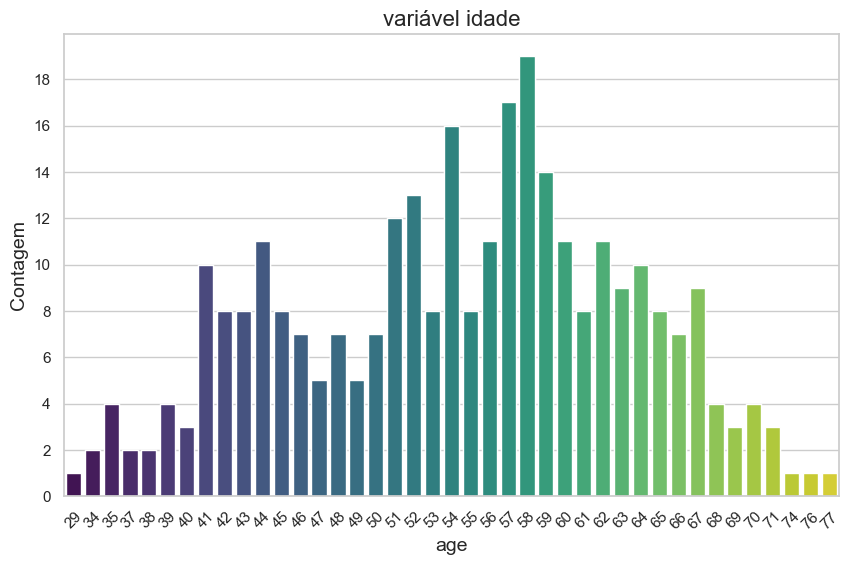

In [5]:
graficodf(df,'age','idade')

C:\Users\Nivaldo\AppData\Local\Temp\ipykernel_4880\3954607923.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=coluna, order=ordem, palette="viridis")


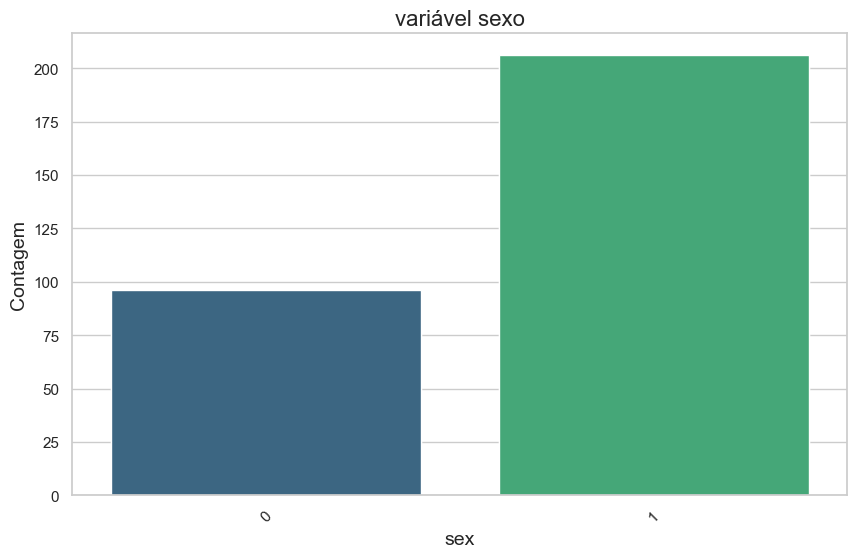

In [6]:
graficodf(df,'sex','sexo')

C:\Users\Nivaldo\AppData\Local\Temp\ipykernel_4880\3954607923.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=coluna, order=ordem, palette="viridis")


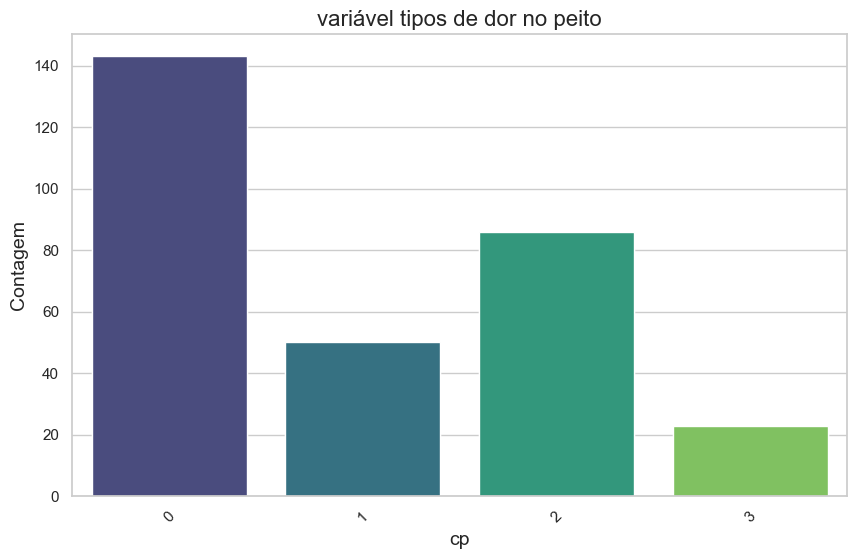

In [7]:
graficodf(df,'cp','tipos de dor no peito')

C:\Users\Nivaldo\AppData\Local\Temp\ipykernel_4880\3954607923.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=coluna, order=ordem, palette="viridis")


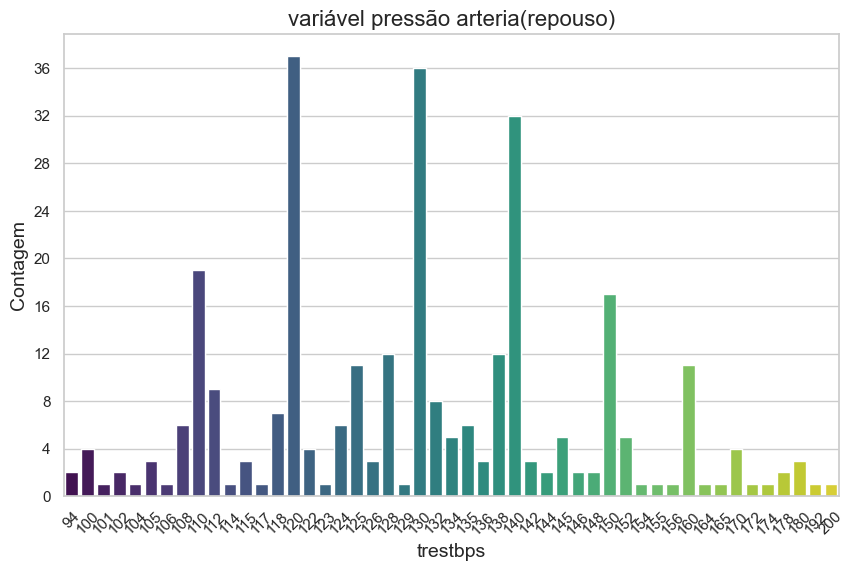

In [8]:
graficodf(df,'trestbps','pressão arteria(repouso)')

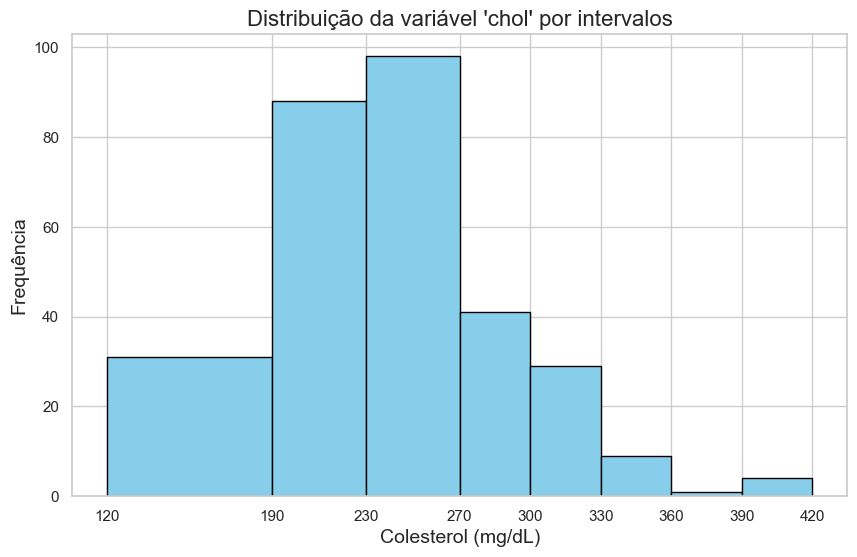

In [9]:
df['chol'] = pd.to_numeric(df['chol'], errors='coerce')

bins = [120, 190, 230, 270,300,330,360,390,420]

plt.figure(figsize=(10, 6))
plt.hist(df['chol'], bins=bins, color='skyblue', edgecolor='black')
plt.title("Distribuição da variável 'chol' por intervalos", fontsize=16)
plt.xlabel("Colesterol (mg/dL)", fontsize=14)
plt.ylabel("Frequência", fontsize=14)
plt.xticks(bins)
plt.show()

C:\Users\Nivaldo\AppData\Local\Temp\ipykernel_4880\3954607923.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=coluna, order=ordem, palette="viridis")


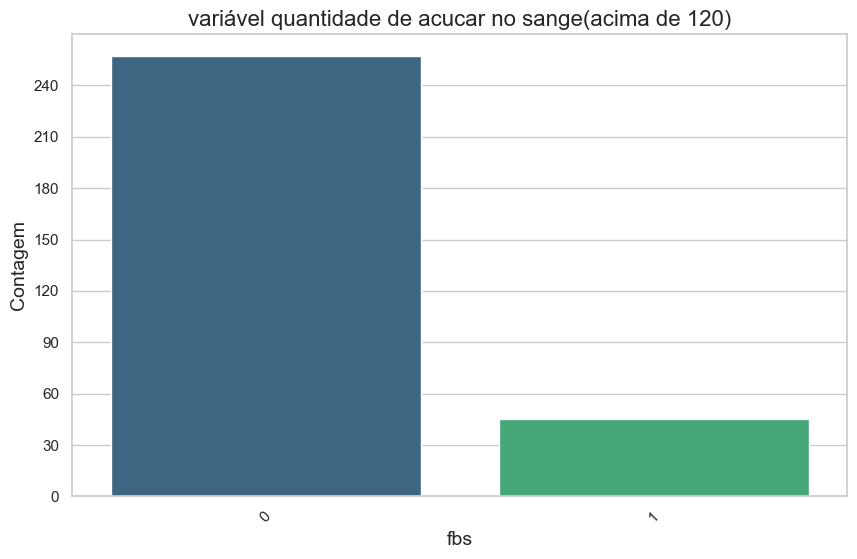

In [10]:
graficodf(df,'fbs','quantidade de acucar no sange(acima de 120)')

C:\Users\Nivaldo\AppData\Local\Temp\ipykernel_4880\3954607923.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=coluna, order=ordem, palette="viridis")


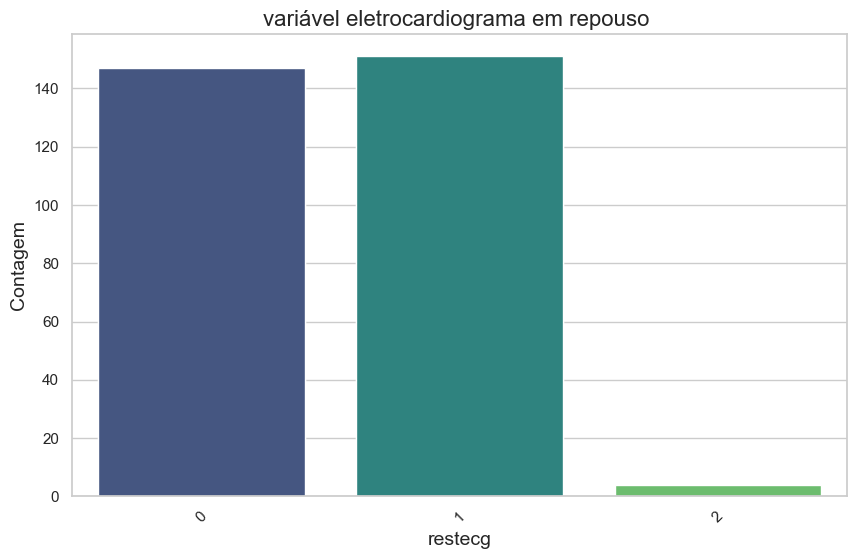

In [11]:
graficodf(df,'restecg','eletrocardiograma em repouso ')

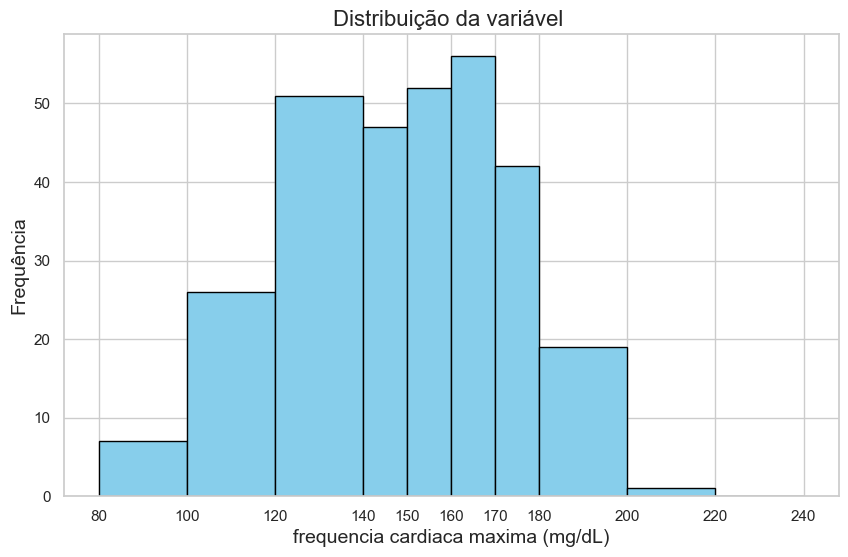

In [12]:
df['thalach'] = pd.to_numeric(df['thalach'], errors='coerce')

bins = [80,100,120,140,150,160,170, 180, 200,220,240]

plt.figure(figsize=(10, 6))
plt.hist(df['thalach'], bins=bins, color='skyblue', edgecolor='black')
plt.title("Distribuição da variável ", fontsize=16)
plt.xlabel("frequencia cardiaca maxima (mg/dL)", fontsize=14)
plt.ylabel("Frequência", fontsize=14)
plt.xticks(bins)
plt.show()

C:\Users\Nivaldo\AppData\Local\Temp\ipykernel_4880\3954607923.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=coluna, order=ordem, palette="viridis")


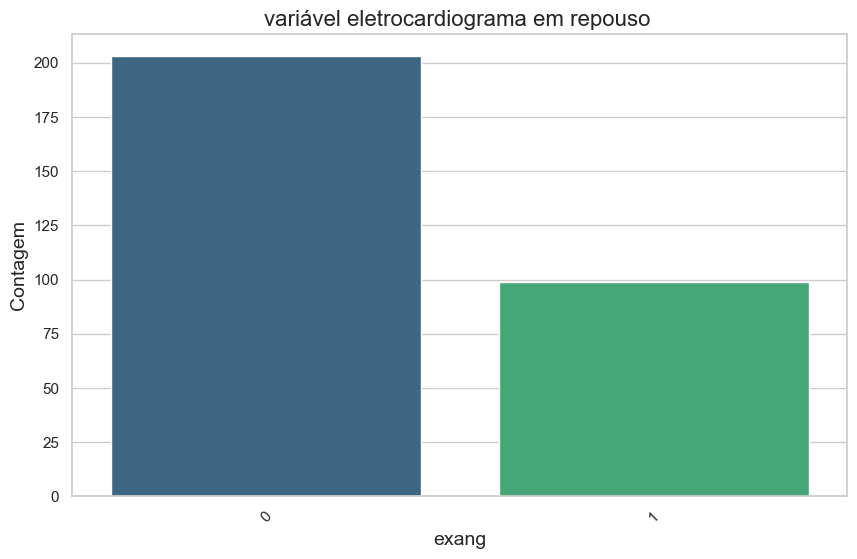

In [13]:
graficodf(df,'exang','eletrocardiograma em repouso ')

C:\Users\Nivaldo\AppData\Local\Temp\ipykernel_4880\3954607923.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=coluna, order=ordem, palette="viridis")


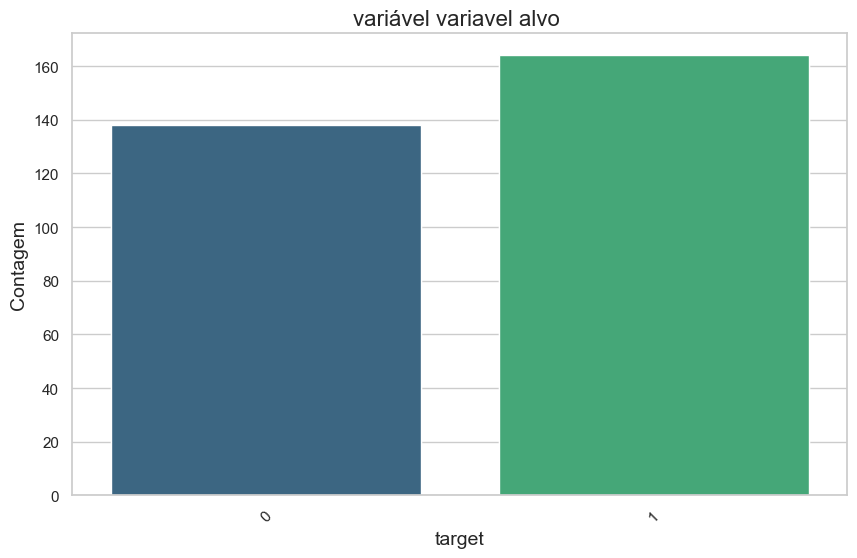

In [14]:
graficodf(df,'target','variavel alvo ')

## matriz de correlação entre os valores

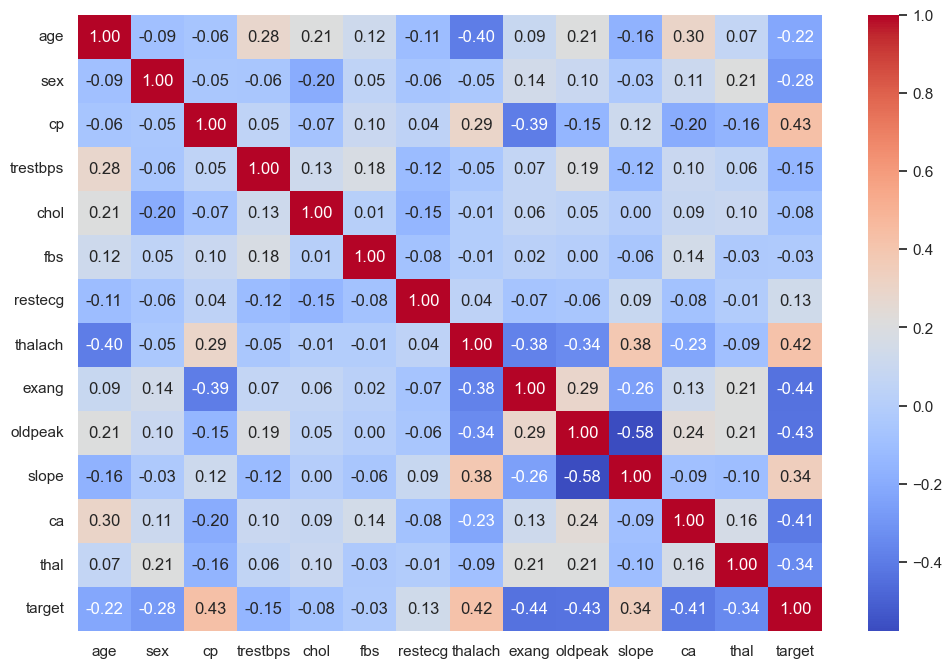

In [15]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

## apos analise percebesse que algumas variaveis são de menor influencia para a analise
## sendp elas as Chol e a FBS

In [16]:
for col_remover in ['chol', 'fbs']:
    if col_remover in df.columns:
        df.drop(columns=[col_remover], inplace=True)
        print(f"Coluna '{col_remover}' removida.")
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

Coluna 'chol' removida.
Coluna 'fbs' removida.


# ## 2. Tratamento de Outliers
# 
### Nesta etapa, definimos uma função para tratar outliers com base no método do Intervalo Interquartílico (IQR).
###
### **Processo:**
### - Calcula Q1 (25º percentil) e Q3 (75º percentil) e o IQR.
### - Define limites inferior e superior como Q1 - 1.5*IQR e Q3 + 1.5*IQR.
### - Se a porcentagem de outliers for inferior a um limiar (5% neste exemplo), removemos as linhas.
### - Caso contrário, aplicamos winsorização (limitação dos valores aos limites).

In [17]:

def tratar_outliers(df, coluna, threshold=0.05):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[coluna] < lower_bound) | (df[coluna] > upper_bound)]
    perc = len(outliers) / len(df)
    print(f"Coluna '{coluna}': {perc*100:.2f}% de outliers encontrados.")
    
    if perc < threshold:
        df = df[(df[coluna] >= lower_bound) & (df[coluna] <= upper_bound)]
        print(f"Outliers removidos para a coluna '{coluna}'.")
    else:
        df[coluna] = np.where(df[coluna] < lower_bound, lower_bound, df[coluna])
        df[coluna] = np.where(df[coluna] > upper_bound, upper_bound, df[coluna])
        print(f"Winsorização aplicada para a coluna '{coluna}'.")
    return df


for col in num_cols:
    df = tratar_outliers(df, col, threshold=0.05)

Coluna 'age': 0.00% de outliers encontrados.
Outliers removidos para a coluna 'age'.
Coluna 'sex': 0.00% de outliers encontrados.
Outliers removidos para a coluna 'sex'.
Coluna 'cp': 0.00% de outliers encontrados.
Outliers removidos para a coluna 'cp'.
Coluna 'trestbps': 2.98% de outliers encontrados.
Outliers removidos para a coluna 'trestbps'.
Coluna 'restecg': 0.00% de outliers encontrados.
Outliers removidos para a coluna 'restecg'.
Coluna 'thalach': 0.34% de outliers encontrados.
Outliers removidos para a coluna 'thalach'.
Coluna 'exang': 0.00% de outliers encontrados.
Outliers removidos para a coluna 'exang'.
Coluna 'oldpeak': 1.37% de outliers encontrados.
Outliers removidos para a coluna 'oldpeak'.
Coluna 'slope': 0.00% de outliers encontrados.
Outliers removidos para a coluna 'slope'.
Coluna 'ca': 7.29% de outliers encontrados.
Winsorização aplicada para a coluna 'ca'.
Coluna 'thal': 0.69% de outliers encontrados.
Outliers removidos para a coluna 'thal'.
Coluna 'target': 0.00%

# ## 3. Conversão de Variáveis e Transformação de Skewness
### 
### **Conversão de Variáveis Categóricas:**
### - Utilizamos o `LabelEncoder` para transformar colunas categóricas (do tipo object) em valores numéricos.
###
### **Transformação de Skewness:**
### - Para cada coluna numérica, calculamos a skewness.
### - Se a assimetria for alta (valor absoluto maior que 1), aplicamos:
###   - Transformação logarítmica (caso todos os valores sejam positivos).
###   - Caso contrário, usamos `log1p` após ajuste.

In [18]:
if cat_cols:
    le = LabelEncoder()
    for col in cat_cols:
        df[col] = le.fit_transform(df[col])
    print("Variáveis categóricas convertidas para numéricas.")
else:
    print("Não foram encontradas colunas categóricas para converter.")

skew_threshold = 1.0
for col in num_cols:
    skew_val = skew(df[col])
    print(f"Skewness da coluna '{col}': {skew_val:.2f}")
    if np.abs(skew_val) > skew_threshold:
        if (df[col] > 0).all():
            df[col] = np.log(df[col])
            print(f"Transformação log aplicada em '{col}'.")
        else:
            df[col] = np.log1p(df[col] - df[col].min() + 1)
            print(f"Transformação log1p aplicada em '{col}'.")


Não foram encontradas colunas categóricas para converter.
Skewness da coluna 'age': -0.17
Skewness da coluna 'sex': -0.82
Skewness da coluna 'cp': 0.46
Skewness da coluna 'trestbps': 0.24
Skewness da coluna 'restecg': 0.10
Skewness da coluna 'thalach': -0.50
Skewness da coluna 'exang': 0.80
Skewness da coluna 'oldpeak': 0.92
Skewness da coluna 'slope': -0.49
Skewness da coluna 'ca': 0.93
Skewness da coluna 'thal': -0.18
Skewness da coluna 'target': -0.24



# ## 4. Dashboards de Exploração de Dados
## 
## **4.1 Distribuição das Variáveis Numéricas:**
## - Criamos histogramas (com KDE) para visualizar a distribuição de cada coluna numérica.
## - O layout dos subplots é gerado dinamicamente com base no número de colunas, organizando 3 gráficos por linha.
##
## **4.2 Heatmap de Correlação:**
## - Exibimos um heatmap para visualizar as correlações entre as variáveis do dataset.


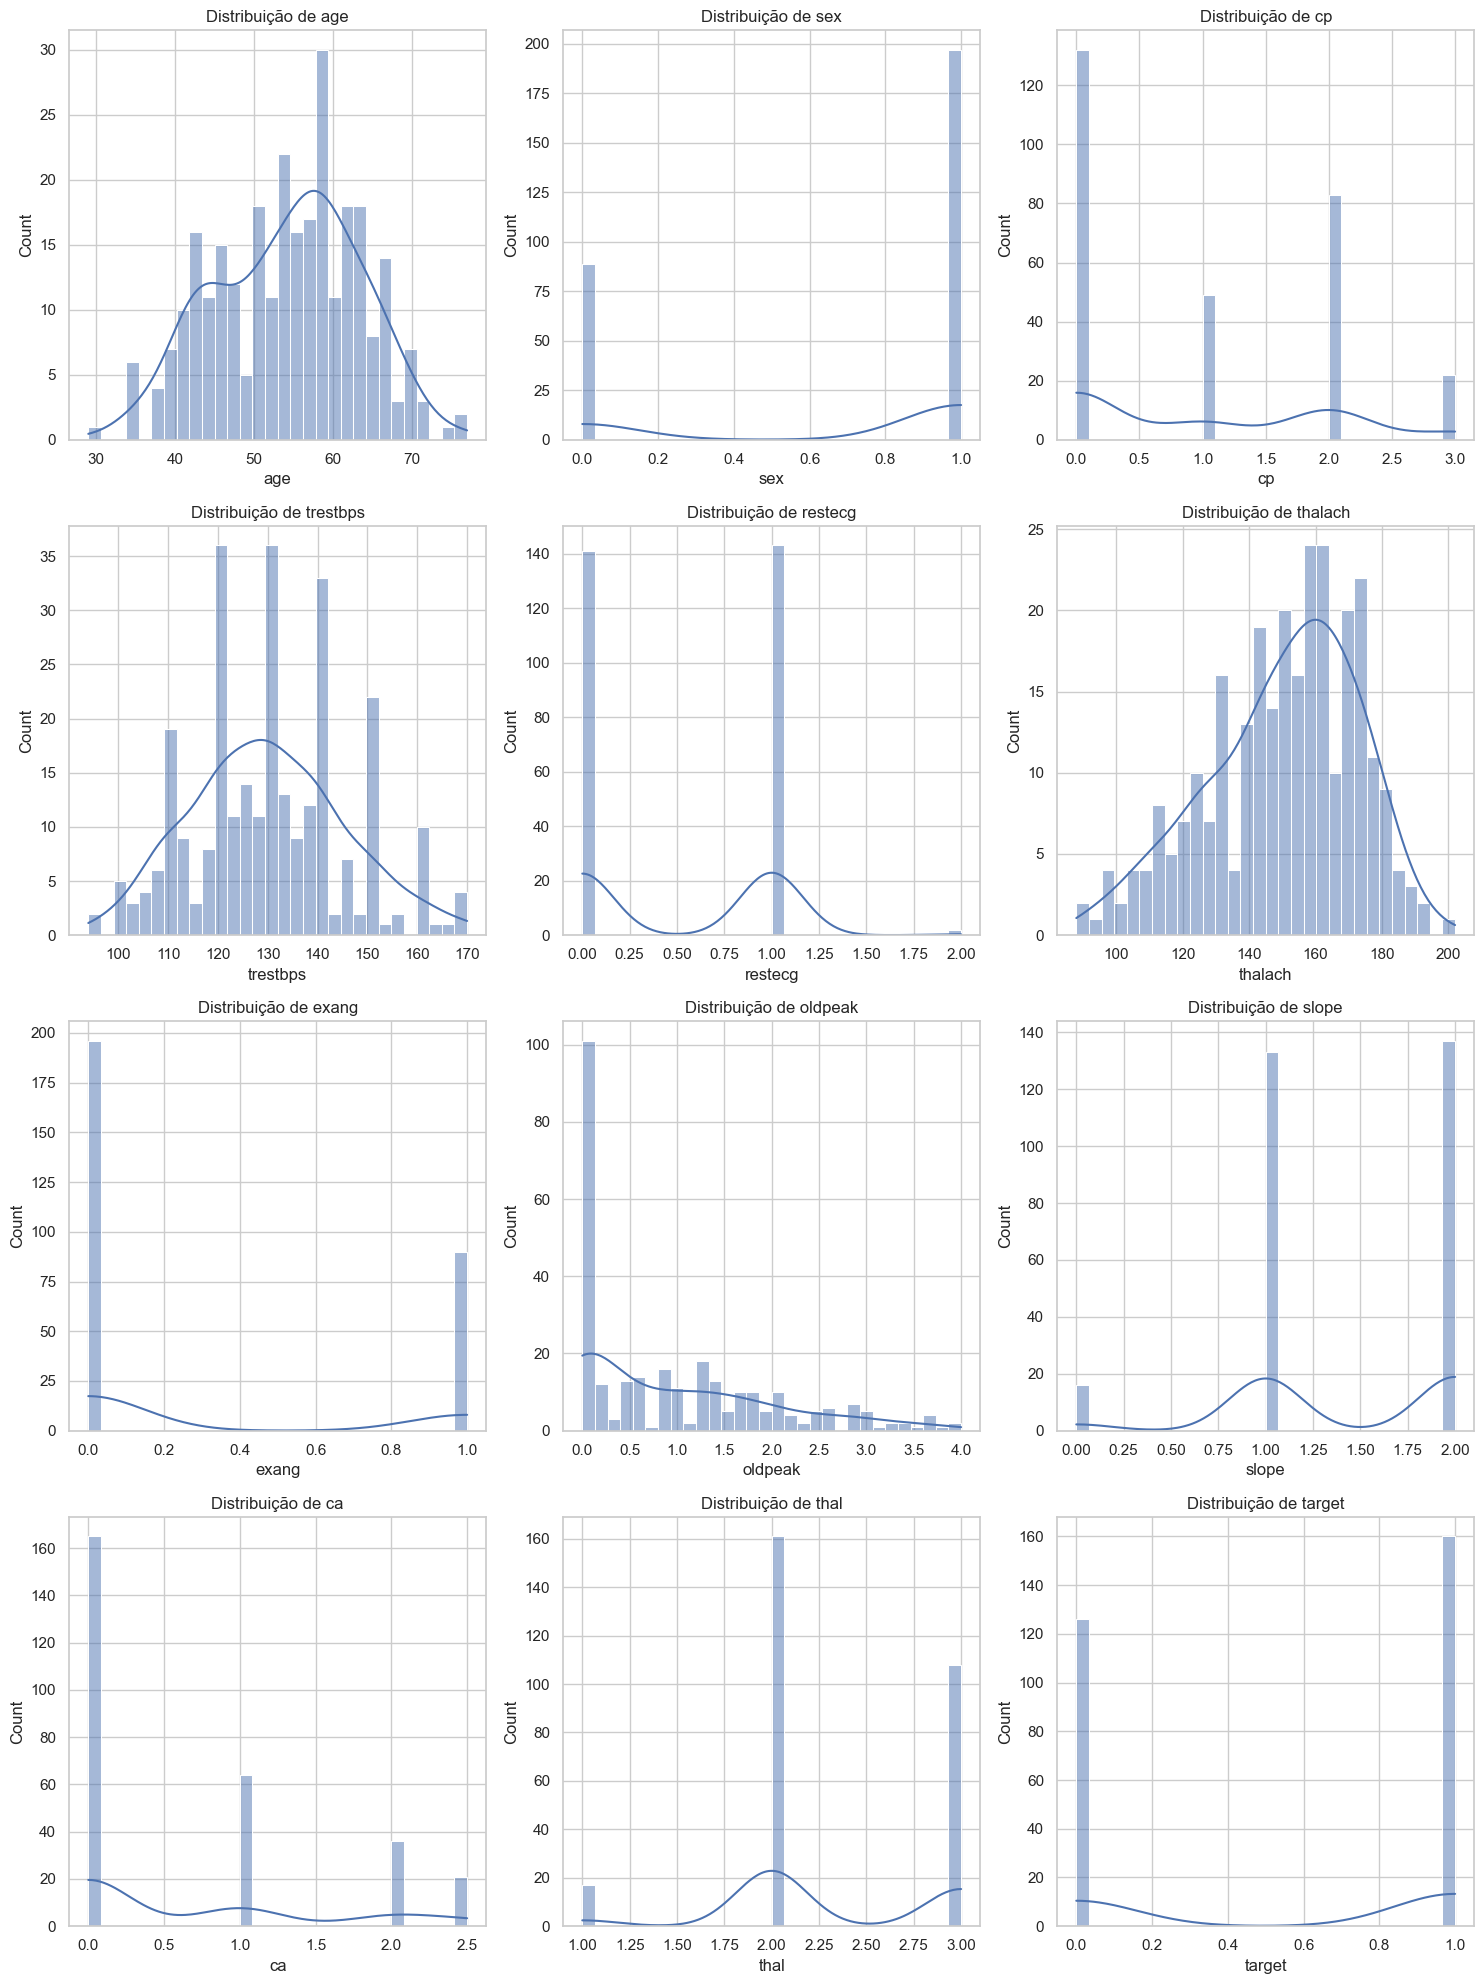

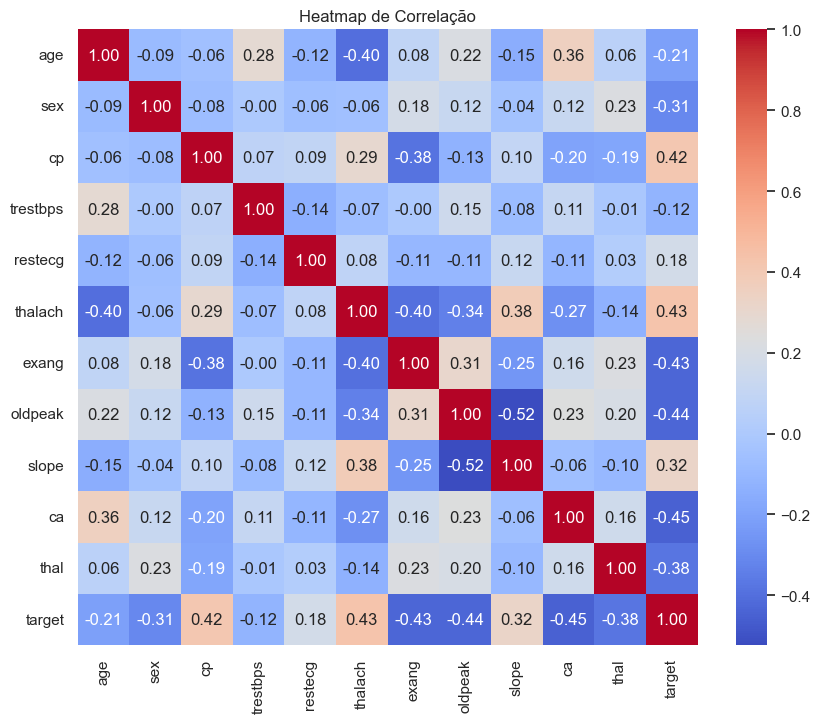

In [19]:
n = len(num_cols)
n_cols_subplot = 3  
n_rows_subplot = math.ceil(n / n_cols_subplot)
plt.figure(figsize=(15, 5 * n_rows_subplot))
for i, col in enumerate(num_cols):
    plt.subplot(n_rows_subplot, n_cols_subplot, i + 1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribuição de {col}")
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Heatmap de Correlação")
plt.show()


# ## 5. Modelagem e Avaliação
### 
### **Processo:**
### - Definimos a coluna alvo (target). Se houver uma coluna chamada "target", ela é usada; caso contrário, a última coluna do DataFrame é considerada alvo.
### - Separamos as features (X) e o target (y) e dividimos os dados em conjuntos de treino e teste.
###
### **Pipelines para Modelos:**
### - Criamos pipelines para os modelos que necessitam de escalonamento (Regressão Logística, SVM e Rede Neural) e para os modelos que não necessitam (Árvore de Decisão e Floresta Aleatória).
### - Para cada pipeline, definimos um grid de hiperparâmetros e utilizamos o `GridSearchCV` para encontrar os melhores parâmetros.
###
### **Métricas de Avaliação:**
### - Avaliamos os modelos com base em Acurácia, Precisão, Recall e F1 Score.

Dimensões do conjunto de treino: (228, 11)
Dimensões do conjunto de teste: (58, 11)
Treinando e ajustando o modelo: Regressão Logística
Resultados para Regressão Logística:
Melhores Parâmetros: {'lr__C': 0.1, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}
Acurácia: 0.8448
Precisão: 0.8800
Recall: 0.7857
F1 Score: 0.8302
---------------------------------------- 

Treinando e ajustando o modelo: SVM
Resultados para SVM:
Melhores Parâmetros: {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
Acurácia: 0.8448
Precisão: 0.8519
Recall: 0.8214
F1 Score: 0.8364
---------------------------------------- 

Treinando e ajustando o modelo: Rede Neural


c:\Users\Nivaldo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Resultados para Rede Neural:
Melhores Parâmetros: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Acurácia: 0.8621
Precisão: 0.8571
Recall: 0.8571
F1 Score: 0.8571
---------------------------------------- 

Treinando e ajustando o modelo: Árvore de Decisão
Resultados para Árvore de Decisão:
Melhores Parâmetros: {'dt__max_depth': 3, 'dt__min_samples_split': 2}
Acurácia: 0.8276
Precisão: 0.8000
Recall: 0.8571
F1 Score: 0.8276
---------------------------------------- 

Treinando e ajustando o modelo: Floresta Aleatória
Resultados para Floresta Aleatória:
Melhores Parâmetros: {'rf__max_depth': 5, 'rf__min_samples_split': 5, 'rf__n_estimators': 50}
Acurácia: 0.8276
Precisão: 0.8462
Recall: 0.7857
F1 Score: 0.8148
---------------------------------------- 

Resumo dos Resultados:


,Melhores Parâmetros,Acurácia,Precisão,Recall,F1 Score
Regressão Logística,"{'lr__C': 0.1, 'lr__penalty': 'l2', 'lr__solve...",0.844828,0.88,0.785714,0.830189
SVM,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",0.844828,0.851852,0.821429,0.836364
Rede Neural,"{'mlp__activation': 'relu', 'mlp__alpha': 0.00...",0.862069,0.857143,0.857143,0.857143
Árvore de Decisão,"{'dt__max_depth': 3, 'dt__min_samples_split': 2}",0.827586,0.8,0.857143,0.827586
Floresta Aleatória,"{'rf__max_depth': 5, 'rf__min_samples_split': ...",0.827586,0.846154,0.785714,0.814815


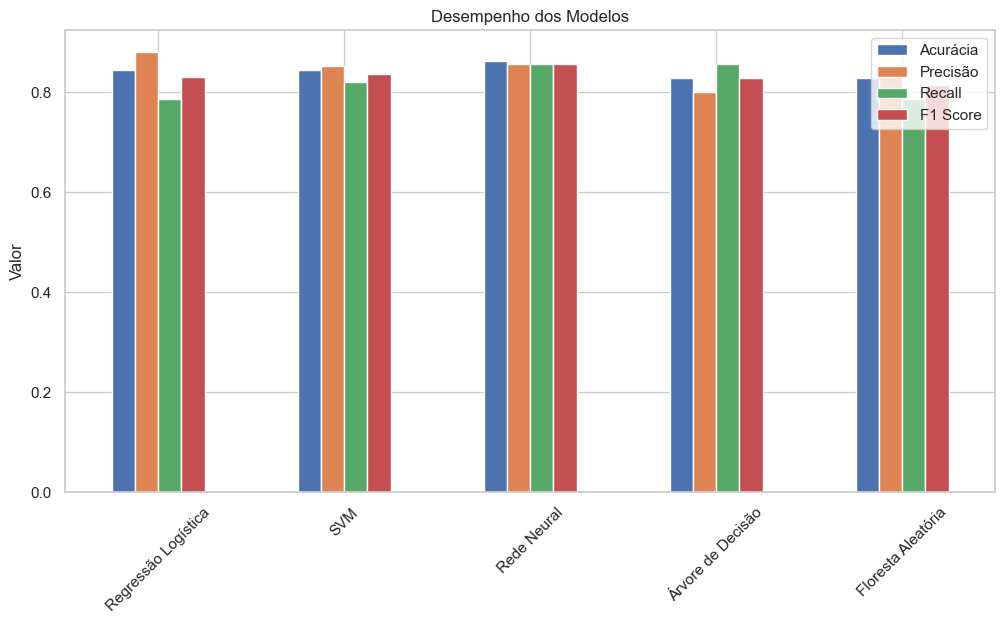

In [20]:
target_col = 'target' if 'target' in df.columns else df.columns[-1]
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Dimensões do conjunto de treino:", X_train.shape)
print("Dimensões do conjunto de teste:", X_test.shape)

pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
])
param_grid_lr = {
    'lr__C': [0.01, 0.1, 1, 10],
    'lr__penalty': ['l2'],
    'lr__solver': ['lbfgs']
}


pipe_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(random_state=42))
])
param_grid_svc = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf'],
    'svc__gamma': ['scale', 'auto']
}


pipe_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(max_iter=1000, random_state=42))
])
param_grid_mlp = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50,50)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [0.0001, 0.001]
}


pipe_dt = Pipeline([
    ('dt', DecisionTreeClassifier(random_state=42))
])
param_grid_dt = {
    'dt__max_depth': [None, 3, 5, 10],
    'dt__min_samples_split': [2, 5, 10]
}


pipe_rf = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])
param_grid_rf = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 3, 5, 10],
    'rf__min_samples_split': [2, 5, 10]
}

modelos = {
    "Regressão Logística": (pipe_lr, param_grid_lr),
    "SVM": (pipe_svc, param_grid_svc),
    "Rede Neural": (pipe_mlp, param_grid_mlp),
    "Árvore de Decisão": (pipe_dt, param_grid_dt),
    "Floresta Aleatória": (pipe_rf, param_grid_rf)
}
resultados = {}
modelos_treinados = {}  

for nome_modelo, (pipeline, param_grid) in modelos.items():
    print(f"Treinando e ajustando o modelo: {nome_modelo}")
    grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    melhor_modelo = grid.best_estimator_
    modelos_treinados[nome_modelo] = melhor_modelo  
    
    y_pred = melhor_modelo.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    resultados[nome_modelo] = {
        "Melhores Parâmetros": grid.best_params_,
        "Acurácia": accuracy,
        "Precisão": precision,
        "Recall": recall,
        "F1 Score": f1
    }
    
    print(f"Resultados para {nome_modelo}:")
    print("Melhores Parâmetros:", grid.best_params_)
    print("Acurácia: {:.4f}".format(accuracy))
    print("Precisão: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1 Score: {:.4f}".format(f1))
    print("-" * 40, "\n")

resultados_df = pd.DataFrame(resultados).T
print("Resumo dos Resultados:")
display(resultados_df)


metrics = ['Acurácia', 'Precisão', 'Recall', 'F1 Score']
resultados_df[metrics].plot(kind='bar', figsize=(12, 6))
plt.title("Desempenho dos Modelos")
plt.ylabel("Valor")
plt.xticks(rotation=45)
plt.legend(loc="best")
plt.show()

=== Avaliação do modelo: Regressão Logística ===


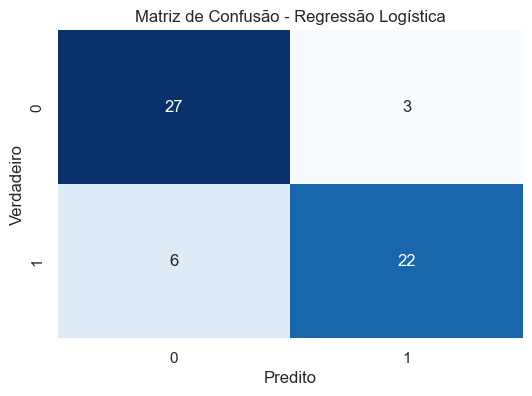

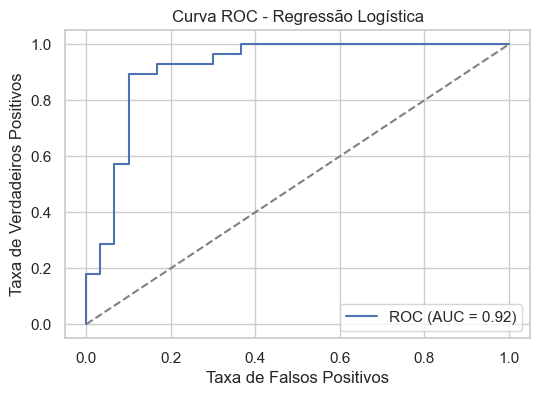

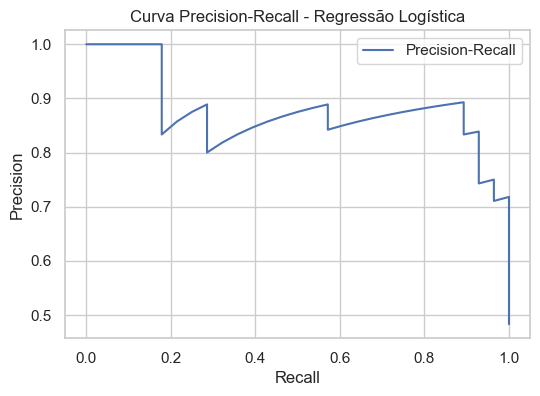

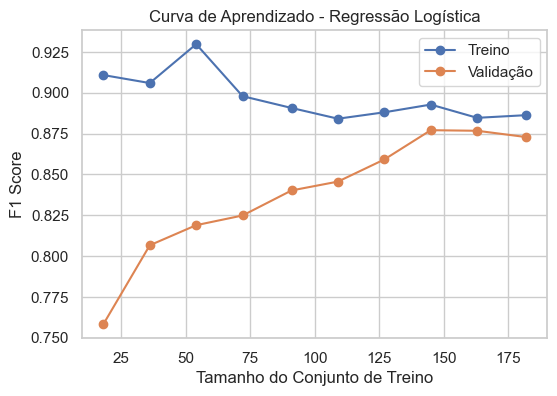

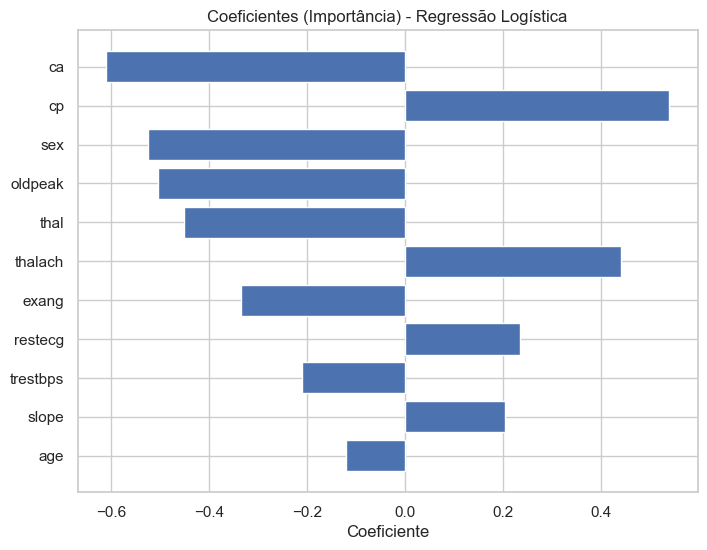



=== Avaliação do modelo: SVM ===


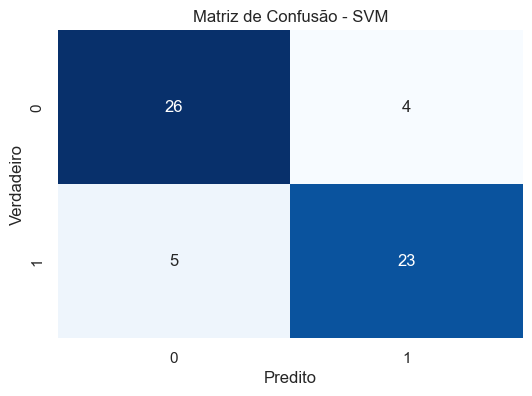

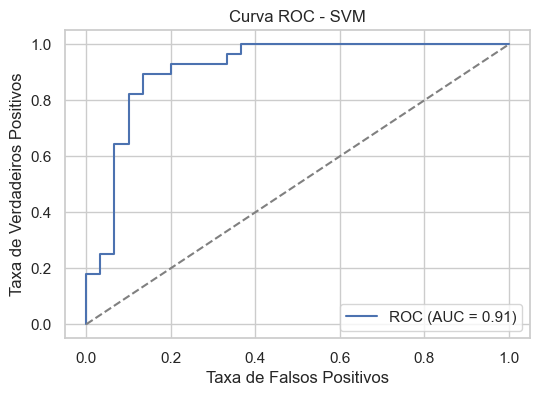

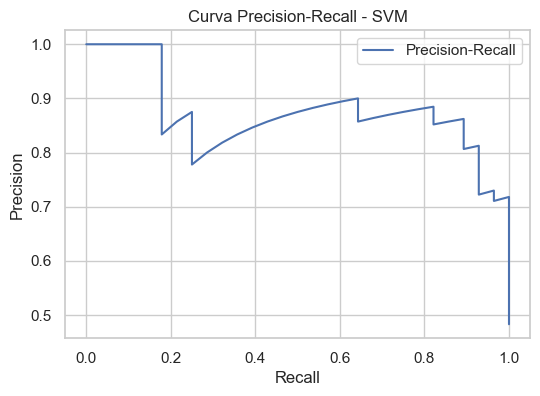

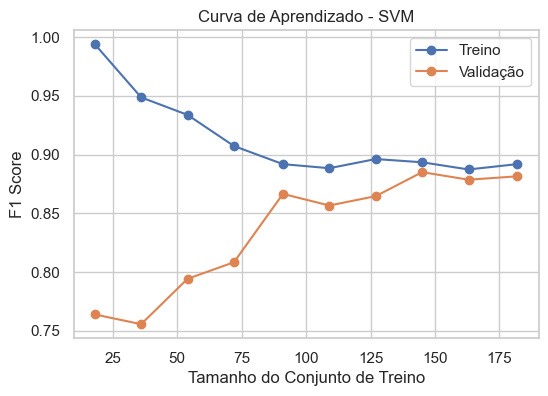

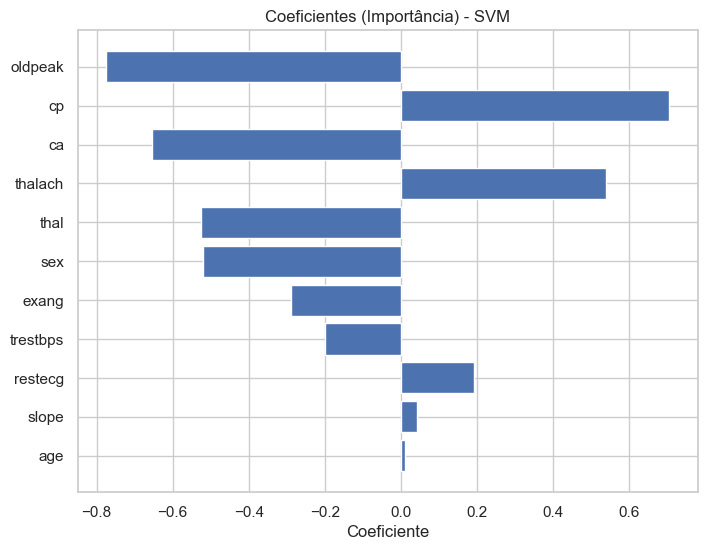



=== Avaliação do modelo: Rede Neural ===


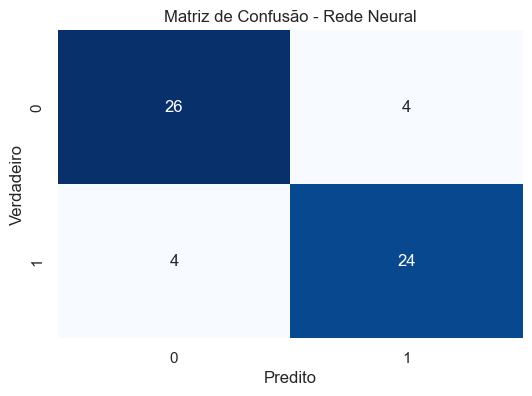

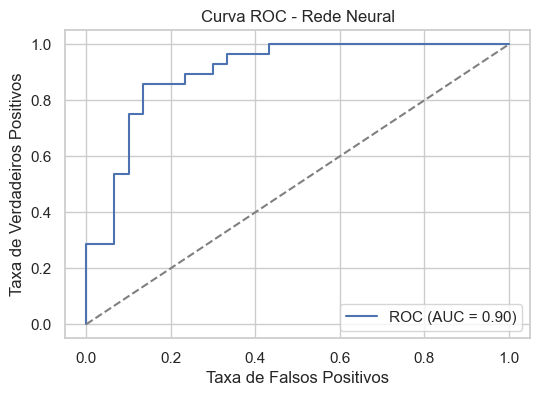

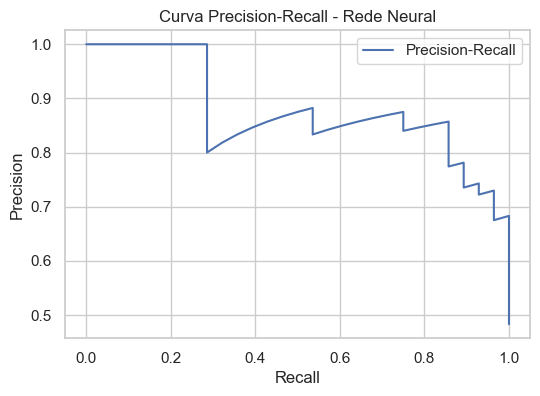

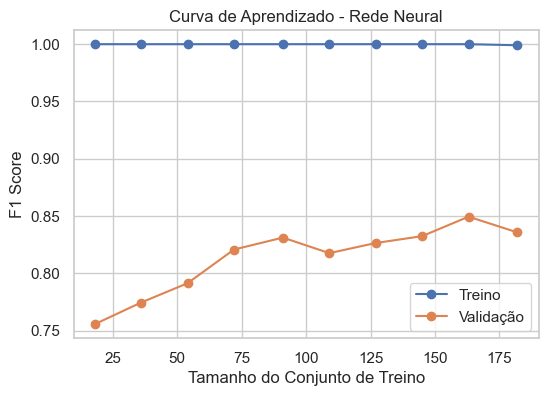

Não há um método direto para extrair coeficientes para o modelo Rede Neural.


=== Avaliação do modelo: Árvore de Decisão ===


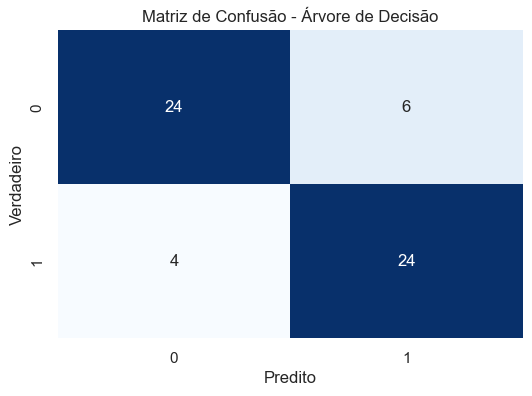

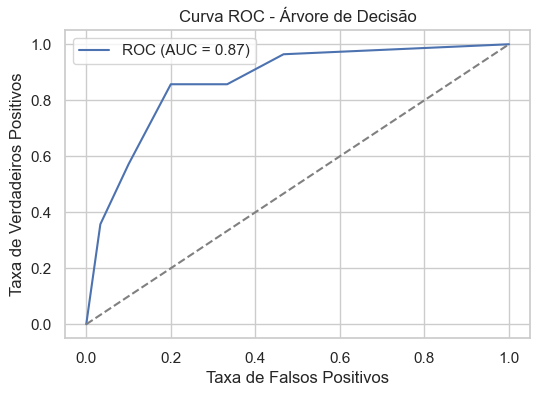

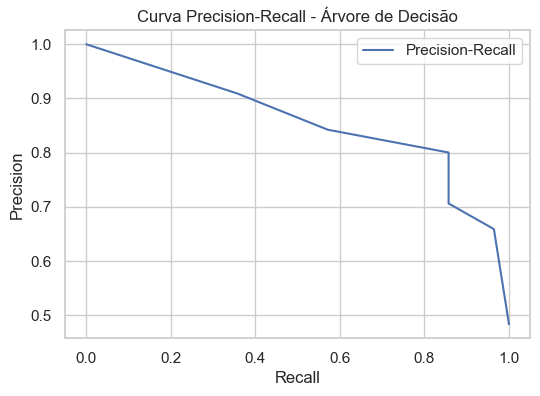

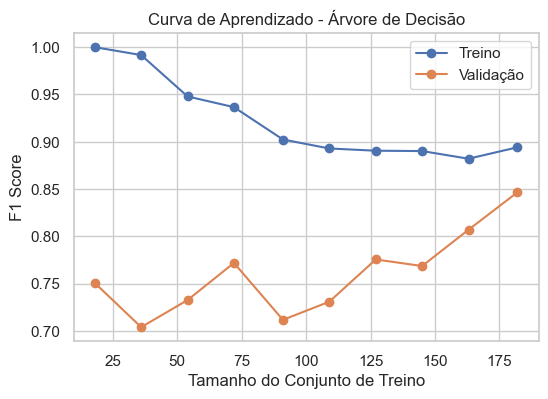

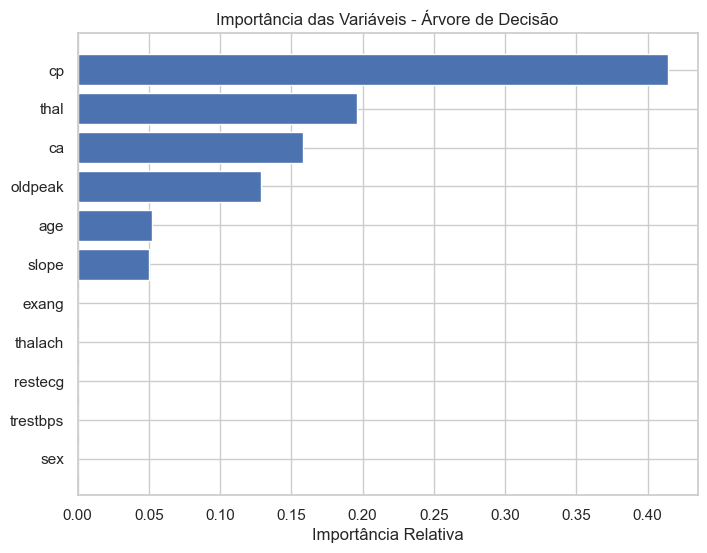



=== Avaliação do modelo: Floresta Aleatória ===


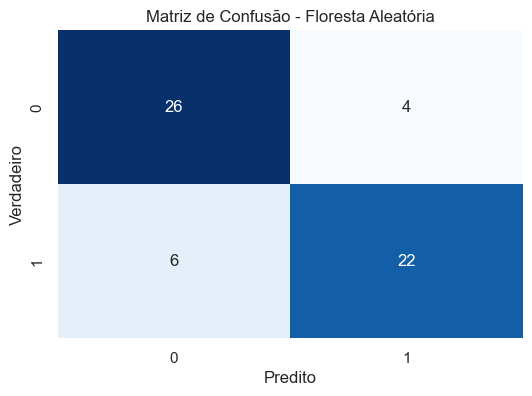

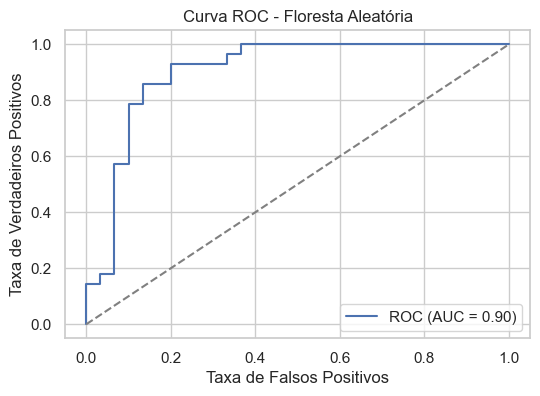

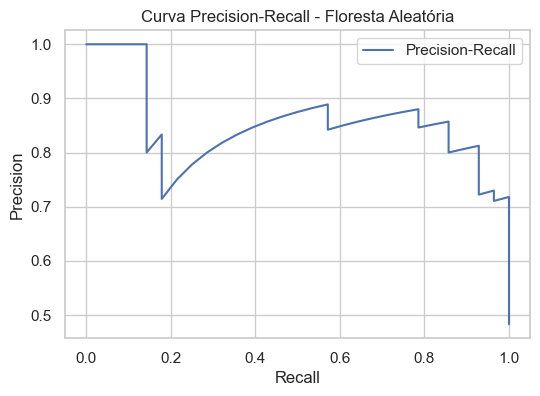

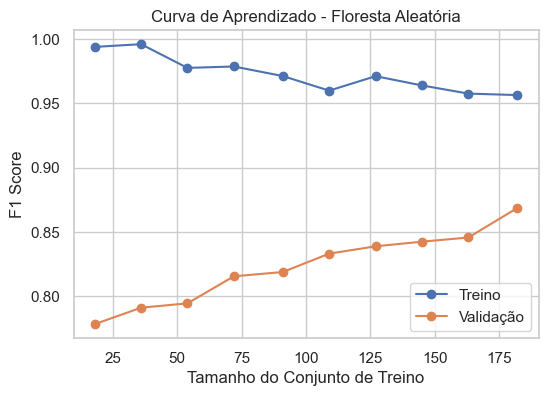

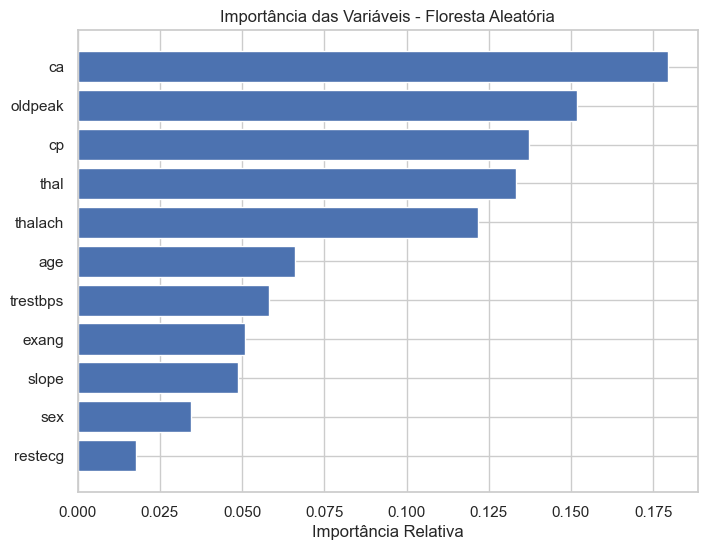

In [21]:
for model_name, pipeline_model in modelos_treinados.items():
    print(f"=== Avaliação do modelo: {model_name} ===")
    
    y_pred = pipeline_model.predict(X_test)
    
    try:
        y_proba = pipeline_model.predict_proba(X_test)[:, 1]
    except AttributeError:
        y_proba = pipeline_model.decision_function(X_test)
    

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Matriz de Confusão - {model_name}")
    plt.xlabel("Predito")
    plt.ylabel("Verdadeiro")
    plt.show()
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("Taxa de Falsos Positivos")
    plt.ylabel("Taxa de Verdadeiros Positivos")
    plt.title(f"Curva ROC - {model_name}")
    plt.legend()
    plt.show()
    
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(recall_vals, precision_vals, label="Precision-Recall")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Curva Precision-Recall - {model_name}")
    plt.legend()
    plt.show()
    
    train_sizes, train_scores, test_scores = learning_curve(
        pipeline_model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10)
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.figure(figsize=(6, 4))
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Treino")
    plt.plot(train_sizes, test_scores_mean, 'o-', label="Validação")
    plt.xlabel("Tamanho do Conjunto de Treino")
    plt.ylabel("F1 Score")
    plt.title(f"Curva de Aprendizado - {model_name}")
    plt.legend(loc="best")
    plt.show()
    

    if model_name in ["Regressão Logística", "SVM"]:
        try:
            if model_name == "Regressão Logística":
                coef = pipeline_model.named_steps['lr'].coef_[0]
            elif model_name == "SVM":
                coef = pipeline_model.named_steps['svc'].coef_[0]
            
            features = X.columns
            indices = np.argsort(np.abs(coef))
            plt.figure(figsize=(8,6))
            plt.title(f"Coeficientes (Importância) - {model_name}")
            plt.barh(range(len(indices)), coef[indices], align='center')
            plt.yticks(range(len(indices)), [features[i] for i in indices])
            plt.xlabel("Coeficiente")
            plt.show()
        except Exception as e:
            print(f"Não foi possível extrair coeficientes para o modelo {model_name}: {e}")
    elif model_name in ["Árvore de Decisão", "Floresta Aleatória"]:
        step = "dt" if model_name == "Árvore de Decisão" else "rf"
        importances = pipeline_model.named_steps[step].feature_importances_
        features = X.columns
        indices = np.argsort(importances)
        plt.figure(figsize=(8, 6))
        plt.title(f"Importância das Variáveis - {model_name}")
        plt.barh(range(len(indices)), importances[indices], color='b', align='center')
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.xlabel("Importância Relativa")
        plt.show()
    else:
        print(f"Não há um método direto para extrair coeficientes para o modelo {model_name}.")
    
    print("\n" + "="*50 + "\n")

